# Neural Cellular Automata Tutorial

## Introduction

Play around with the animation at this [link](https://distill.pub/2020/growing-ca/), on the right you can change some parameters.  

In this notebook you will learn how the Cellular Automata model behind that animation works and how it is trained.  
And you will train a Neural Cellular Automata that represents your favourite image.

## Recap on Cellular Automata

We introduce Cellular Automata (CA) using a simple example. Think of an automaton as a one-dimensional grid of cells. Each of them can only instantiate one of two states; let us say that each cell can be turned on or off. The evolution of the system is determined by a transition rule, which is applied to each cell. At each time step, each cell updates its state in response to what happens to its neighboring cells, following the rule.

One of the simplest CA is the hat rule, where each cell stands for a student wearing (black) or not wearing (white) a hat. Let us make the two following assumptions: 

Hat rule: a student will wear the hat in the next class if one or the other, but not both, of the two classmates sitting immediately on her left and on her right has the hat in the current class (if nobody wears a hat, a hat is out of fashion; but if both neighbors wear it, a hat is now too popular to be trendy).

Initial class: during the first class in the morning, only one student in the middle shows up with a hat (see Fig. 2).

We can readily implement the hat rule in python

In [62]:
from typing import List
import pylab as pl

class HatRule:
    """The classroom is represented as a list of int where 1 is a student with a hat and 0 is a student without a hat"""
    def __init__(self, size: int = 50):
        self.size = size
        self.classroom = self.get_initial_classroom(size)

    @staticmethod
    def get_initial_classroom(size: int) -> List[int]:
        # In the first class of the morning only the student in the middle has a hat
        classroom = [0] * size
        classroom[size // 2] = 1
        return classroom

    def set_classroom(self, classroom: List[int]):
        self.classroom = classroom
    
    def get_classroom(self) -> List[int]:
        return self.classroom.copy()

    def step(self) -> List[int]:
        ## TODO: Write the update rule of the hat rule, to avoid boundary problems avoid updating the cells at the boundary
        next_classroom = self.classroom.copy()
        for i in range(1, self.size - 1):
            next_classroom[i] = (self.classroom[i - 1] + self.classroom[i + 1]) % 2
        return next_classroom

    def evolve(self, n_steps: int) -> List[int]:
        for _ in range(n_steps):
            self.classroom = self.step()
        return self.classroom.copy()

    def plot_evolution(self, n_steps: int = 100):
        classrooms = [self.get_classroom()]
        for _ in range(n_steps):
            classrooms.append(self.evolve(1))
        pl.matshow(classrooms)

If you implemented correctly the `step` method, below you should see a triangular shaped fractal, which is in fact [Sierpiński triangle](https://en.wikipedia.org/wiki/Sierpi%C5%84ski_triangle)

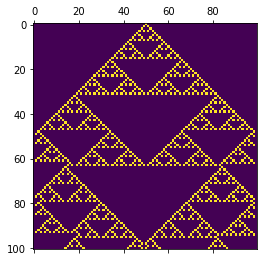

In [64]:
rule = HatRule(size=100)
rule.plot_evolution(n_steps=100)

The evolutionary pattern displayed contrasts with the simplicity of the underlying law (the “Hat rule”) [...]. The global, emergent behavior of the system supervenes upon its local, simple features.

### CA definition

A rigorus mathematical definition of a CA can be found [here](https://plato.stanford.edu/entries/cellular-automata/#SomeBasiNotiResu), however, a more intuitive definition is:

A Cellular Automata (CA) consists of a grid of cells that is iteratively updated using the same update rule at each step, the only requirement is that the next state of each cell depends only on its previous state $x_t$ and the state of its neighbors $N(x_t)$.
$$x_{t+1}= f(x_t , N(x_t))$$


### 2) CA as Convolutional Neural Networks

CA have a clear parallelism to Convolutional Neural Networks (CNN), in this section we will demonstrate this by implementing the hat rule using pytorch convolution operation.

The operator is F.conv1d, its documentation can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv1d.html#torch.nn.functional.conv1d).
Using it we can quickly implement function that computes the running average of a signal.

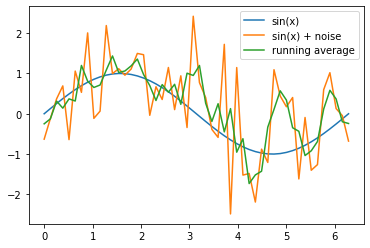

In [84]:
import torch
import torch.nn.functional as F
import numpy as np

def running_average(input, window_size=3):
    weight = torch.ones(window_size) / window_size
    # The operator F.conv1d(input, weight) expects as input tensor of shape (batch_size, n_channels, signal_length), in our case (1, 1, *)
    # and as weight a tensor of shape (batch_size, n_channels, filter_length), in our case (1, 1, window_size)
    # This is why we need to reshape the input and weight tensors, and then unravel the output tensor
    return F.conv1d(input.view(1, 1, -1), weight.view(1, 1, -1), padding="same").ravel()

n_points = 50
x = torch.linspace(0, 2 * np.pi, n_points)
y = torch.sin(x)
y_noisy = y + torch.randn(n_points)

pl.plot(x, y, label="sin(x)")
pl.plot(x, y_noisy, label="sin(x) + noise")
pl.plot(x, running_average(y_noisy), label="running average")
pl.legend()

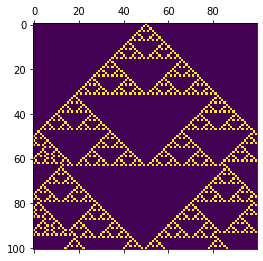

In [110]:
class HatRulePytorch:
    def __init__(self, size: int = 50):
        self.size = size
        self.classroom = self.get_initial_classroom(size)

    @staticmethod
    def get_initial_classroom(size: int) -> List[int]:
        # In the first class of the morning only the student in the middle has a hat
        classroom = torch.zeros(size, dtype=torch.int8)
        classroom[size // 2] = 1
        return classroom

    def set_classroom(self, classroom: List[int]):
        self.classroom = classroom
    
    def get_classroom(self) -> List[int]:
        return self.classroom.clone()

    def step(self) -> List[int]:
        ## TODO: Write the update rule of the hat rule using pytorch convolution, to avoid boundary problems avoid updating the cells at the boundary
        weight = torch.tensor([1, 0, 1], dtype=torch.int8)
        return F.conv1d(self.classroom.view(1, 1, -1), weight.view(1, 1, -1), padding="same").ravel() % 2

    def evolve(self, n_steps: int) -> List[int]:
        for _ in range(n_steps):
            self.classroom = self.step()
        return self.classroom.clone()

    def plot_evolution(self, n_steps: int = 100):
        classrooms = [self.get_classroom()]
        for _ in range(n_steps):
            classrooms.append(self.evolve(1))

        pl.matshow(torch.cat(classrooms, 0).view(n_steps+1, -1))


rule = HatRulePytorch(100)
rule.plot_evolution(100)

### 3) Neural Cellular Automata

Up until now we have dealt with discrete states, while we have shown that these models, although simple, exhibit complex macroscopic behaviour, it is very difficult to find a CA that, starting from a given initial state, reaches a target state. The main problem, is that we can't apply gradient based optimization, because the update rule, having discrete input and output, is not differentiable. Researchers have tried to tackle this using genetic algorithms, which don't require gradient information, however, even finding rules that converge to very simple patterns appears to be difficult, I won't go into a full explanation of why this is, which can be found here, however, the idea is that if you change the rule slightly, the resulting pattern will be completely different, or put it differently: rules similar in definition are far apart in behaviour. This limits the applicability of genetic algorithms.

Neural Cellular Automata (NCA) solve this problem by considering the state $x$ to be continuous and use a neural network to model the rule. This allows to train the rule using gradient-based optimization.